# Differentiable Forwards Modelled Interferrometry

This little tutorial is designed to give an overview of how to forwards-model fit interferrometric observables directly to data, including aberratios and detector effects.

In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

import jax
import jax.numpy as np
import dLux as dl
import dLux.utils as dlu

jax.config.update("jax_enable_x64", True)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

In [2]:
from lib import get_files, summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    "/Users/louis/Data/JWST/COM1093/stage2/",
    "cal",
    EXP_TYPE="NIS_AMI",
    PATTTYPE="NONE",
    FILTER="F480M",
    OBSERVTN=["013", "016", "019"],
    ** kwargs,
)

stars = ["AB-DOR", "HD-37093", "HD-36805"]

files = []
for star in stars:
    fs = file_fn(TARGPROP=star)
    print(f"\n{len(fs)}")
    summarise_files(fs, ["ACT_ID"])
    files += fs


print(f"\n{len(files)}")
summarise_files(files, ["ACT_ID", "NGROUPS", "NINTS", "DURATION"])


2
  TARGPROP: AB-DOR
  TARGNAME: HD 36705
  FILTER: F480M
  OBSERVTN: 013
  PATTTYPE: NONE
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  DATAMODL: ImageModel
  INSTRUME: NIRISS
  EXP_TYPE: NIS_AMI
  ACT_ID: 02, 05

1
  TARGPROP: HD-37093
  TARGNAME: HD 37093
  FILTER: F480M
  OBSERVTN: 016
  PATTTYPE: NONE
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  DATAMODL: ImageModel
  INSTRUME: NIRISS
  EXP_TYPE: NIS_AMI
  ACT_ID: 02

1
  TARGPROP: HD-36805
  TARGNAME: HD 36805
  FILTER: F480M
  OBSERVTN: 019
  PATTTYPE: NONE
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  DATAMODL: ImageModel
  INSTRUME: NIRISS
  EXP_TYPE: NIS_AMI
  ACT_ID: 02

4
  TARGPROP: AB-DOR, HD-36805, HD-37093
  TARGNAME: HD 36805, HD 36705, HD 37093
  FILTER: F480M
  OBSERVTN: 016, 013, 019
  PATTTYPE: NONE
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  DATAMODL: ImageModel
  INSTRUME: NIRISS
  EXP_TYPE: NIS_AMI
  ACT_ID: 02, 0

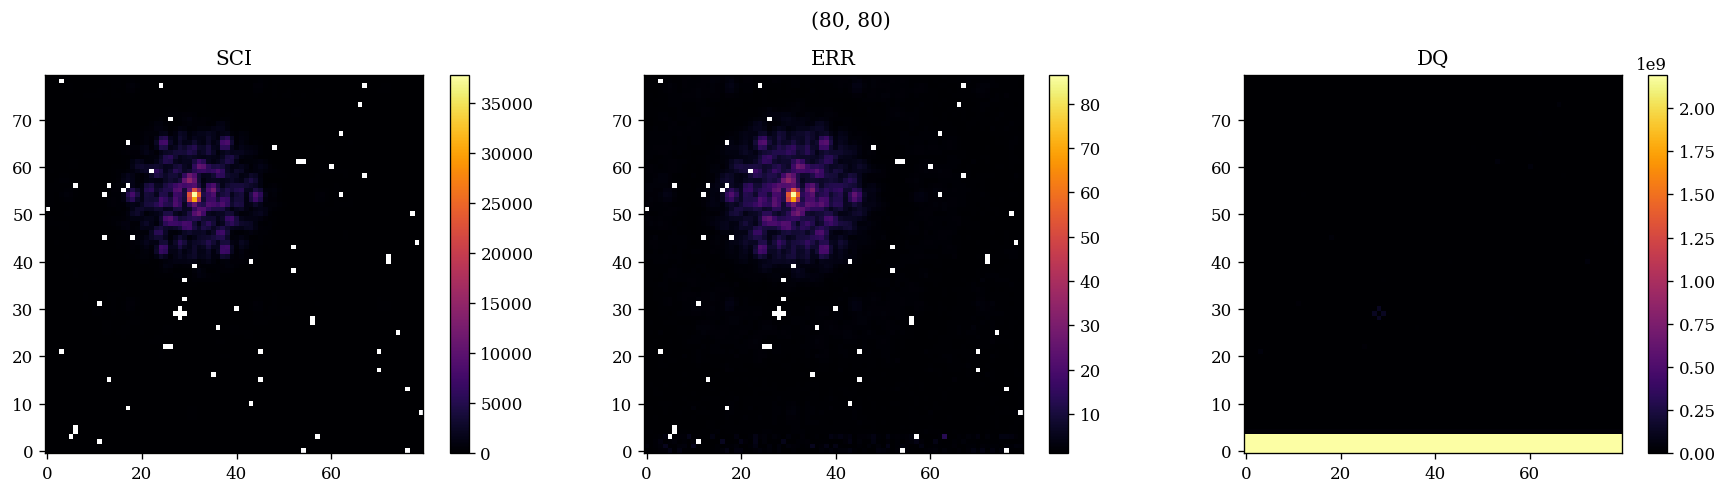

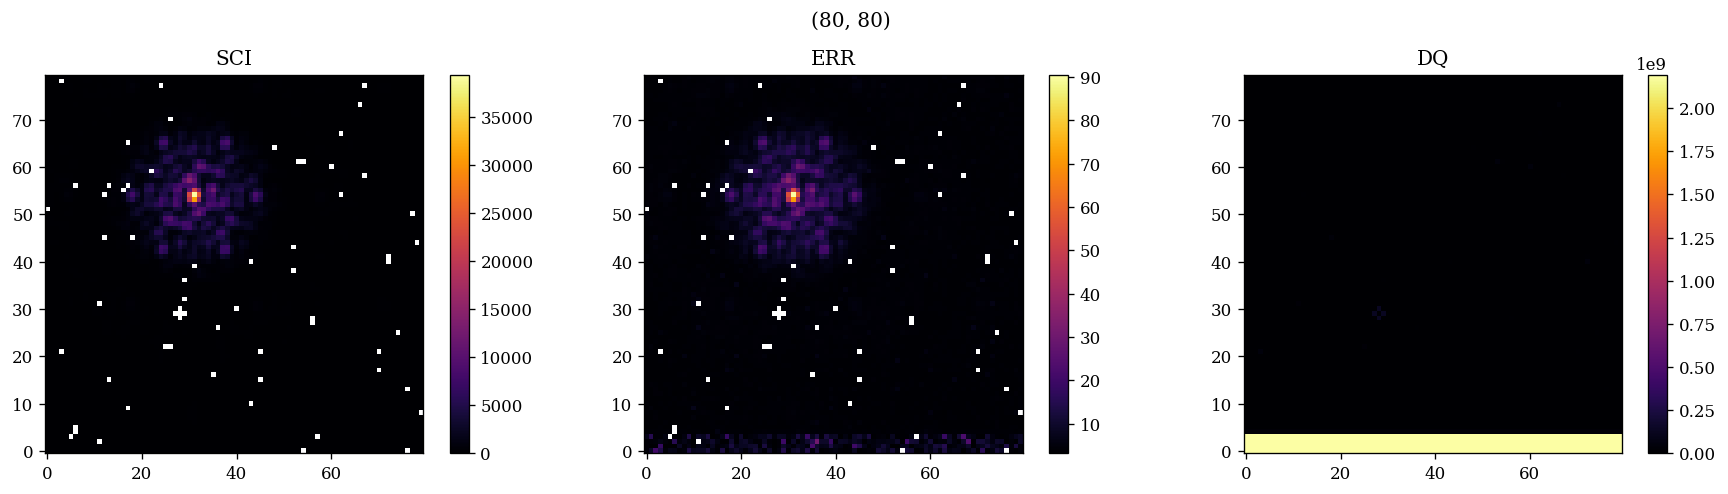

In [3]:
from lib import plot_image

for file in files[:2]:
    plot_image(file, 0)

In [4]:
from jax import lax


def FIM(pytree, parameters, loglike_fn, *loglike_args, shape_dict={}, **loglike_kwargs):
    # Build X vec
    pytree = zdx.tree.set_array(pytree, parameters)
    shapes, lengths = zdx.bayes._shapes_and_lengths(pytree, parameters, shape_dict)
    X = np.zeros(zdx.bayes._lengths_to_N(lengths))

    # Build function to calculate FIM and calculate
    @jax.hessian
    def calc_fim(X):
        parametric_pytree = _perturb(X, pytree, parameters, shapes, lengths)
        return loglike_fn(parametric_pytree, *loglike_args, **loglike_kwargs)

    return calc_fim(X)


def _perturb(X, pytree, parameters, shapes, lengths):
    n, xs = 0, []
    if isinstance(parameters, str):
        parameters = [parameters]
    indexes = range(len(parameters))

    for i, param, shape, length in zip(indexes, parameters, shapes, lengths):
        if length == 1:
            xs.append(X[i + n])
        else:
            xs.append(lax.dynamic_slice(X, (i + n,), (length,)).reshape(shape))
            n += length - 1

    return pytree.add(parameters, xs)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


  0%|          | 0/4 [00:00<?, ?it/s]

Plotting: AB-DOR_F480M_013_05


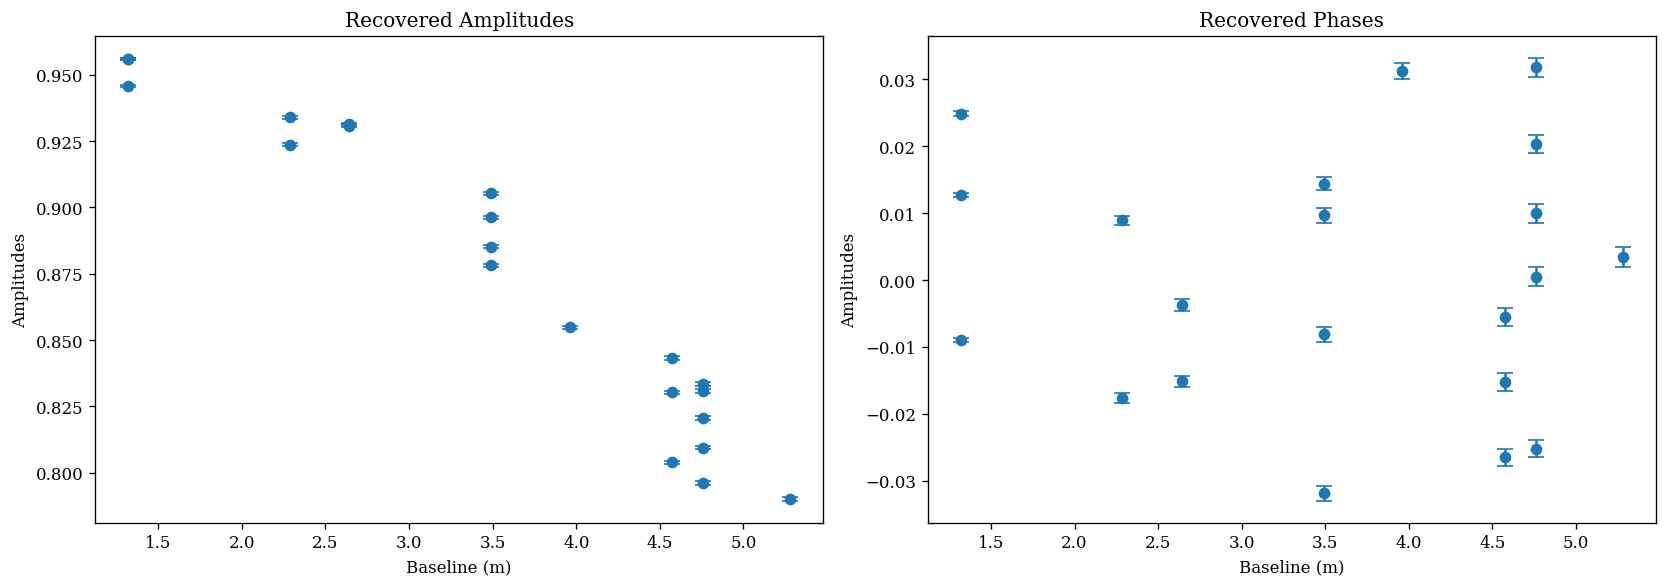

Plotting: AB-DOR_F480M_013_02


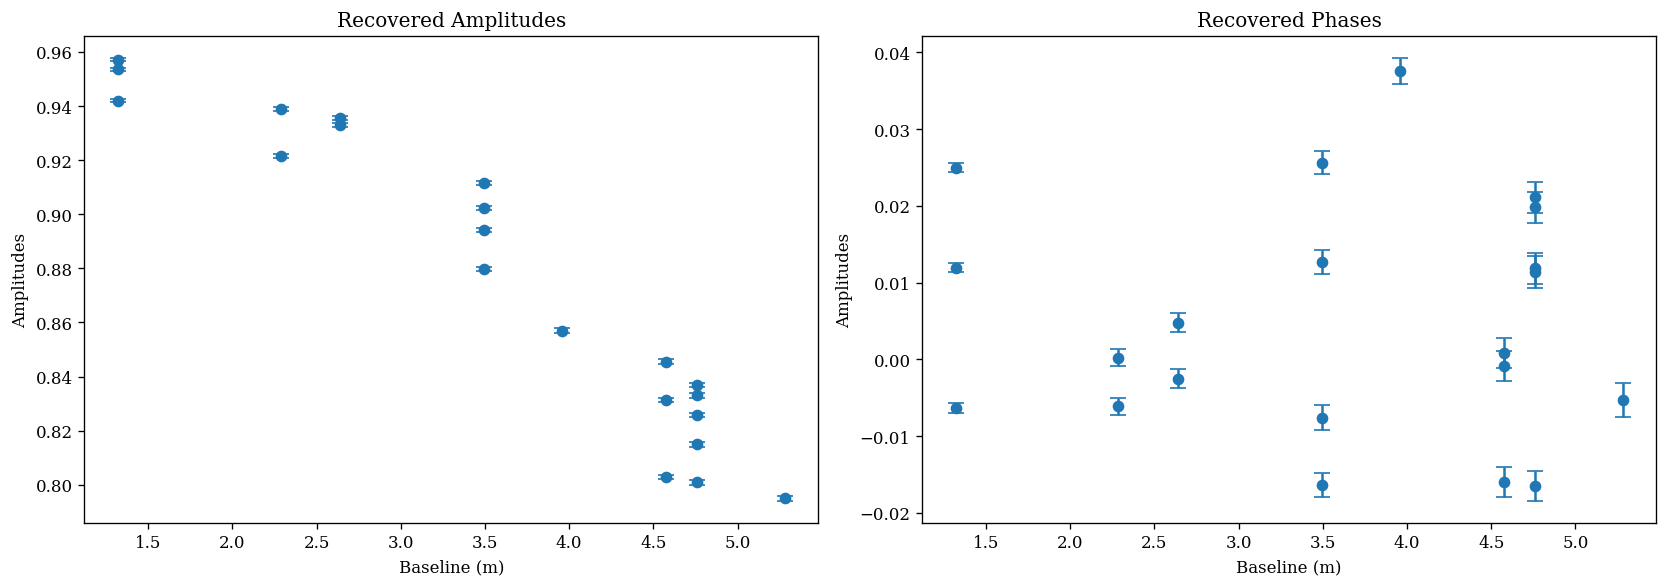

Plotting: HD-37093_F480M_016_02


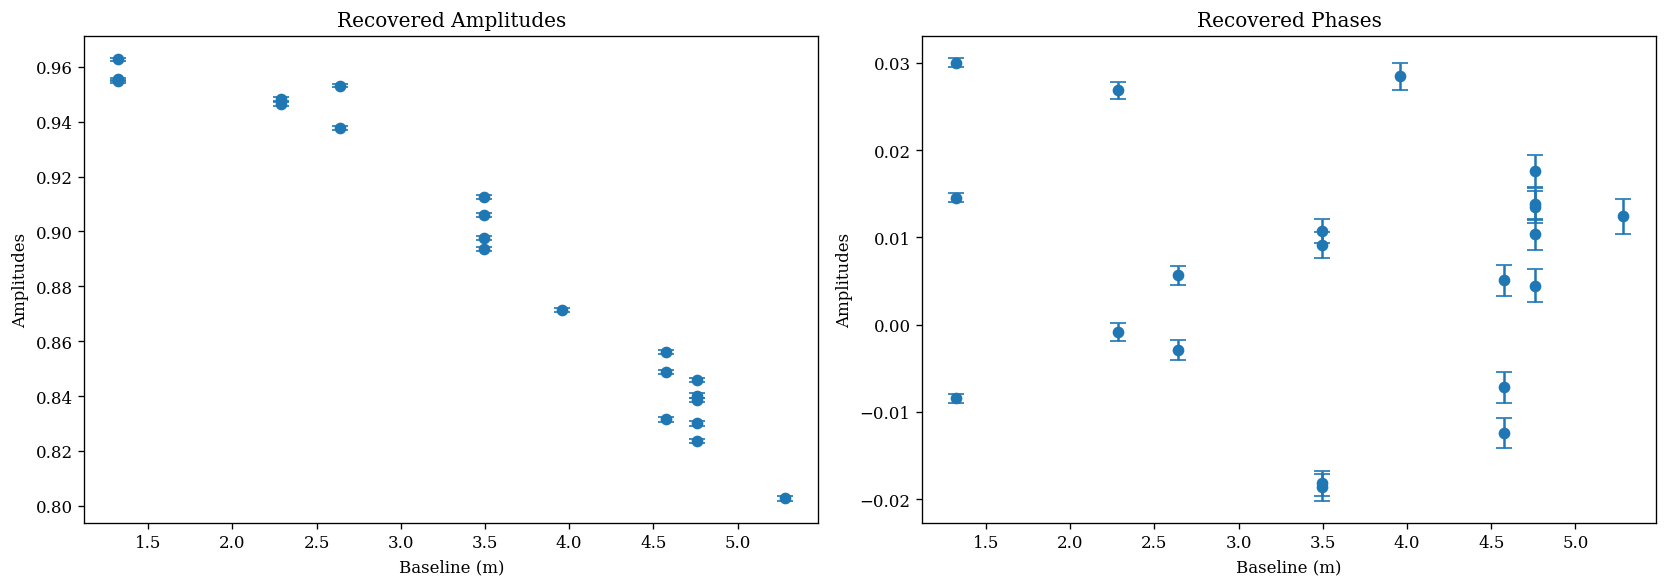

Plotting: HD-36805_F480M_019_02


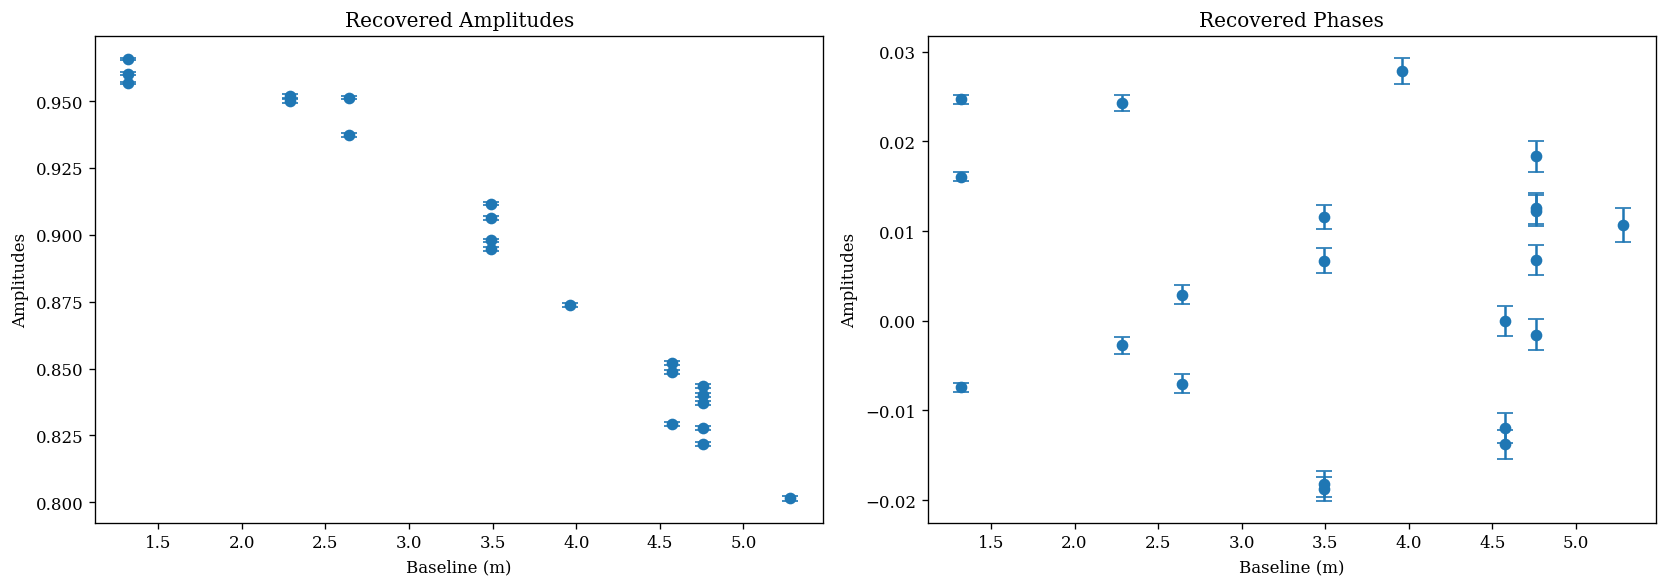

In [5]:
import os
from lib import get_webb_osys_fits
from lib import compare, initialise_for_data
from lib import UVSource, get_AMI_splodge_mask, Null
from lib import get_nan_support, show_likelihoods
from lib import loglike_fn, like_fn
from lib import show_splodges
from nrm_analysis.misctools import mask_definitions
from lib import pairwise_vectors

from zodiax.experimental import serialise, deserialise

import zodiax as zdx
import dLuxWebbpsf as dlw

sci_vis = []
sci_fims = []
cal_vis = []
cal_fims = []
for file in tqdm(files):
    head = file[0].header
    name = f"{head["TARGPROP"]}_{head["FILTER"]}_{head["OBSERVTN"]}_{head["ACT_ID"]}"
    print(f"Plotting: {name}")
    
    try:
        losses = 1e-4 * np.load(f"files/losses/{name}.npy")
        model = deserialise(f"files/models/{name}.zdx")
        params_out = deserialise(f"files/params/{name}.zdx")
    except FileNotFoundError:
        print("File not found")
        continue

    models_out = []
    for i in range(len(losses)):
        new_model = model
        for param, values in params_out.items():
            new_model = new_model.set(param, values[i])
        models_out.append(new_model)

    if os.path.exists(f"files/fims/{name}.npy"):
        fim = np.load(f"files/fims/{name}.npy")
    else:
        im = np.array(file[1].data).astype(float)
        err = np.array(file[2].data).astype(float)
        support, support_mask = get_nan_support(file, n_mask=3, order=2) 
        params = ["flux", "position", "amplitudes", "phases"]
        llike_fn = lambda model: loglike_fn(model, im, err, support).sum()
        fim = FIM(models_out[-1], params, llike_fn, shape_dict={})
        np.save(f"files/fims/{name}", fim)
    
    cov = -np.linalg.inv(fim)
    stds = np.abs(np.diag(cov)) ** 0.5
    N = 21
    ampl_err = stds[-2*N:-N]
    phase_err = stds[-N:]

    if head['TARGPROP'] == 'AB-DOR':
        sci_vis.append(models_out[-1].visibilities)
        sci_fims.append(fim)
    else:
        cal_vis.append(models_out[-1].visibilities)  
        cal_fims.append(fim)

    hbls = pairwise_vectors(mask_definitions.jwst_g7s6c()[1])
    bls_r = np.array(np.hypot(hbls[:, 0], hbls[:, 1]))
    # bls_r = np.concatenate([np.zeros(1), bls_r])  # Add DC term

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.title("Recovered Amplitudes")
    plt.errorbar(bls_r, models_out[-1].amplitudes, yerr=ampl_err, fmt="o", capsize=5)
    # plt.scatter(bls_r, models_out[-1].amplitudes)
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

    plt.subplot(1, 2, 2)
    plt.title("Recovered Phases")
    plt.errorbar(bls_r, models_out[-1].phases, yerr=phase_err, fmt="o", capsize=5)
    # plt.scatter(bls_r, models_out[-1].phases)
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

    plt.tight_layout()
    plt.show()

fims = {"sci": sci_fims, "cal": cal_fims}
visibilities = {"sci": sci_vis, "cal": cal_vis}

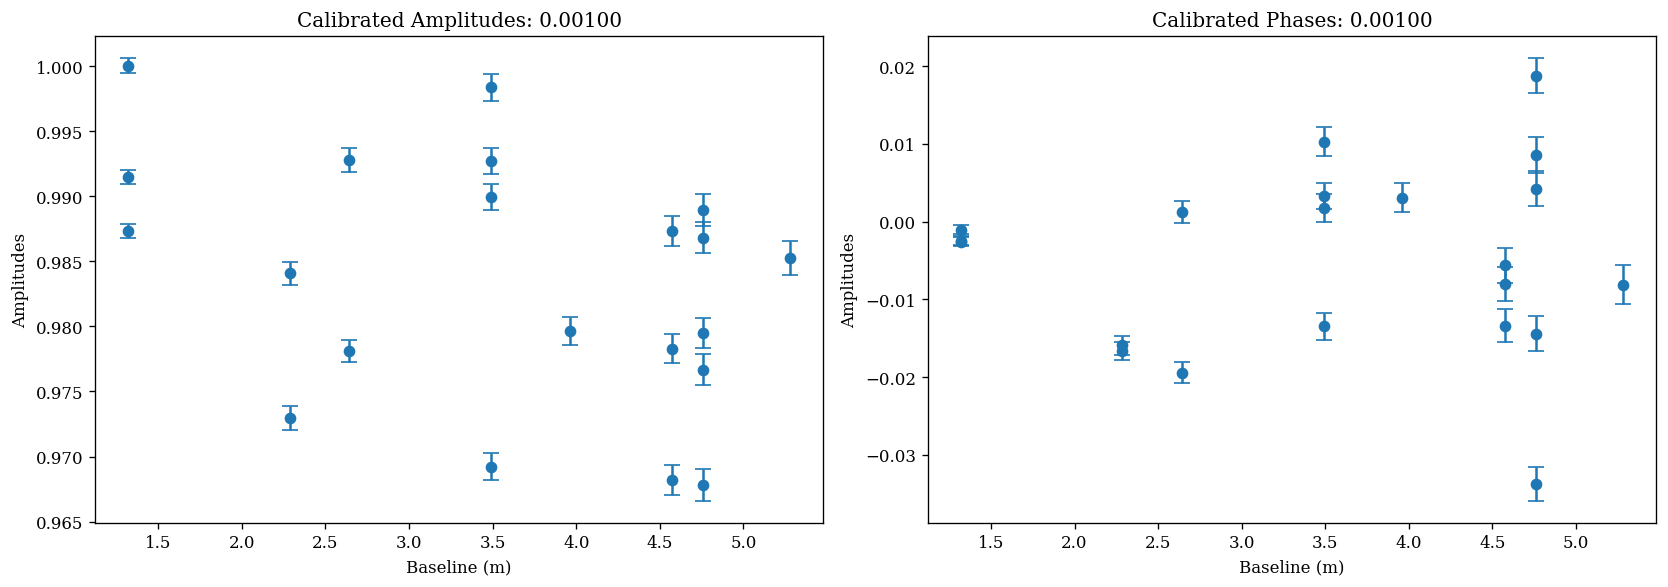

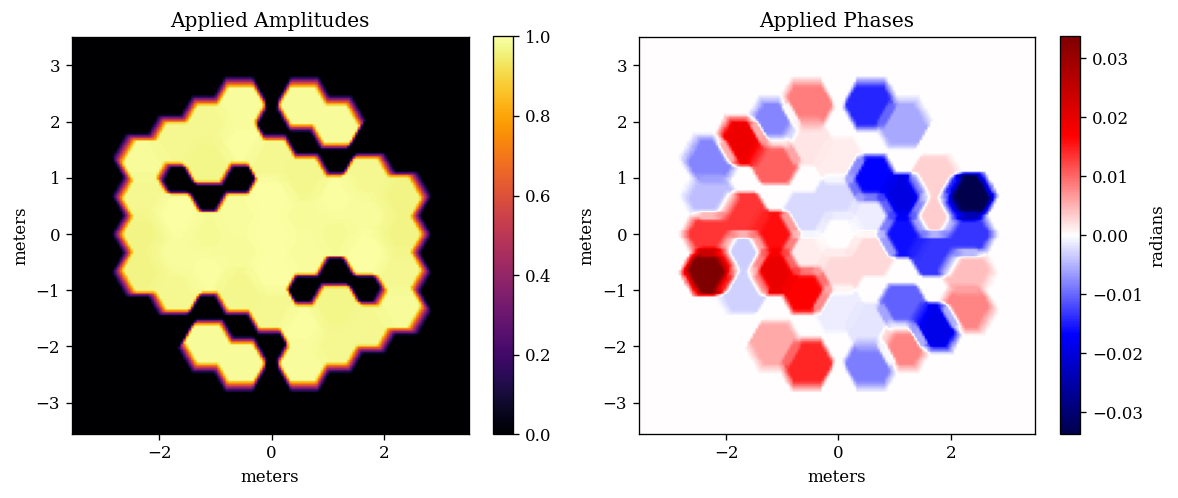

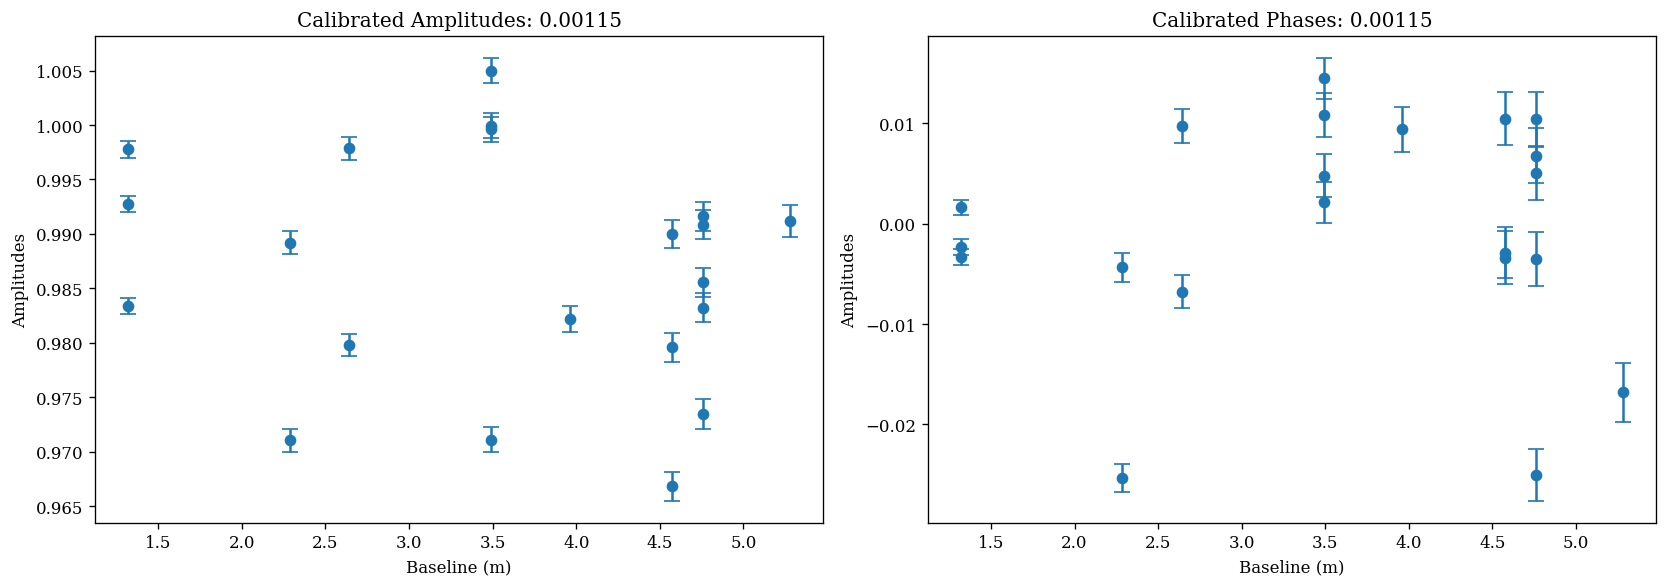

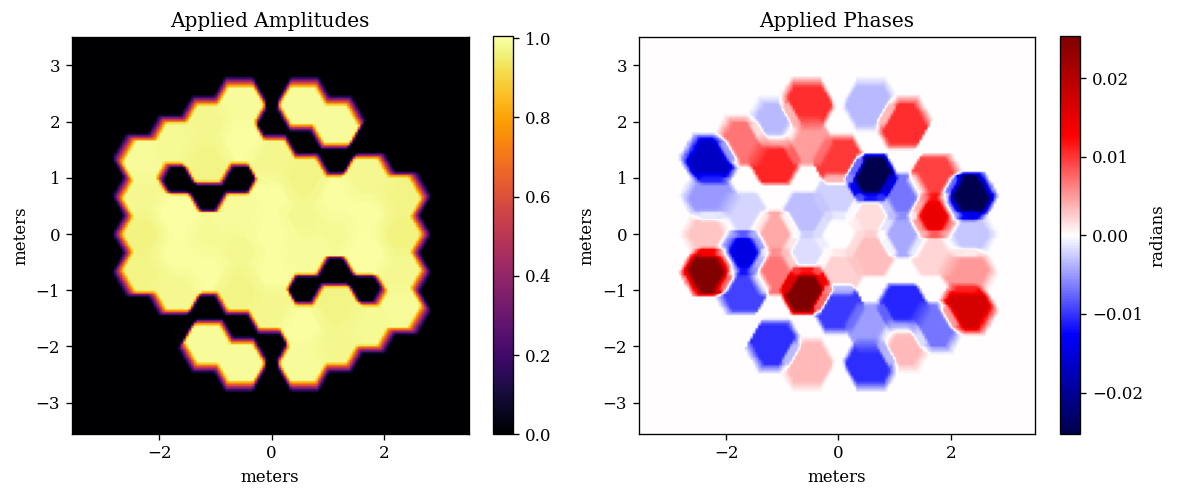

In [6]:
from uncertainties import ufloat
import numpy as onp

N = 21
# sci_idx = 0
for sci_idx in [0, 1]:
    cal_idx = 1

    # Calibrate visibilities
    sci_vis = visibilities["sci"][sci_idx]
    # cal_vis = visibilities["cal"][cal_idx]
    cal_vis = np.array(visibilities["cal"]).mean(0)

    vis_calibrated = sci_vis / cal_vis
    ampls = np.abs(vis_calibrated)
    phases = np.angle(vis_calibrated)

    # Get amplitudes and phases
    sci_ampl = np.abs(sci_vis)
    sci_phase = np.angle(sci_vis)
    cal_ampl = np.abs(cal_vis)
    cal_phase = np.angle(cal_vis)

    # Get covariances and standard deviations
    sci_fim = fims["sci"][sci_idx]
    sci_cov = -np.linalg.inv(sci_fim)
    sci_std = np.abs(np.diag(sci_cov)) ** 0.5

    # cal_fim = fims["cal"][cal_idx]
    cal_fim = np.array(fims["cal"]).mean(0)
    cal_cov = -np.linalg.inv(cal_fim)
    cal_std = np.abs(np.diag(cal_cov)) ** 0.5

    # Calculate amplitude errors
    a_arr = onp.array([ufloat(a, s) for a, s in zip(sci_ampl, sci_std[-2 * N : -N])])
    b_arr = onp.array([ufloat(a, s) for a, s in zip(cal_ampl, cal_std[-2 * N : -N])])
    ampl_err = np.array([(a / b).std_dev for a, b, in zip(a_arr, b_arr)])

    # Calculate phase errors
    a_arr = onp.array([ufloat(a, s) for a, s in zip(sci_phase, sci_std[-N:])])
    b_arr = onp.array([ufloat(a, s) for a, s in zip(cal_phase, cal_std[-N:])])
    phase_err = np.array([(a - b).std_dev for a, b, in zip(a_arr, b_arr)])

    # ampl_err = np.hypot(sci_std[-2 * N : -N], cal_std[-2 * N : -N])
    # phase_err = np.hypot(sci_std[-N:], cal_std[-N:])

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.title(f"Calibrated Amplitudes: {ampl_err.mean():.5f}")
    plt.errorbar(bls_r, ampls, yerr=ampl_err, fmt="o", capsize=5)
    # plt.scatter(bls_r, ampls)
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

    plt.subplot(1, 2, 2)
    plt.title(f"Calibrated Phases: {ampl_err.mean():.5f}")
    plt.errorbar(bls_r, phases, yerr=phase_err, fmt="o", capsize=5)
    # plt.scatter(bls_r, phases)
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

    plt.tight_layout()
    plt.show()

    model = models_out[-1].set(["amplitudes", "phases"], [ampls, phases])
    show_splodges(model, s=75)

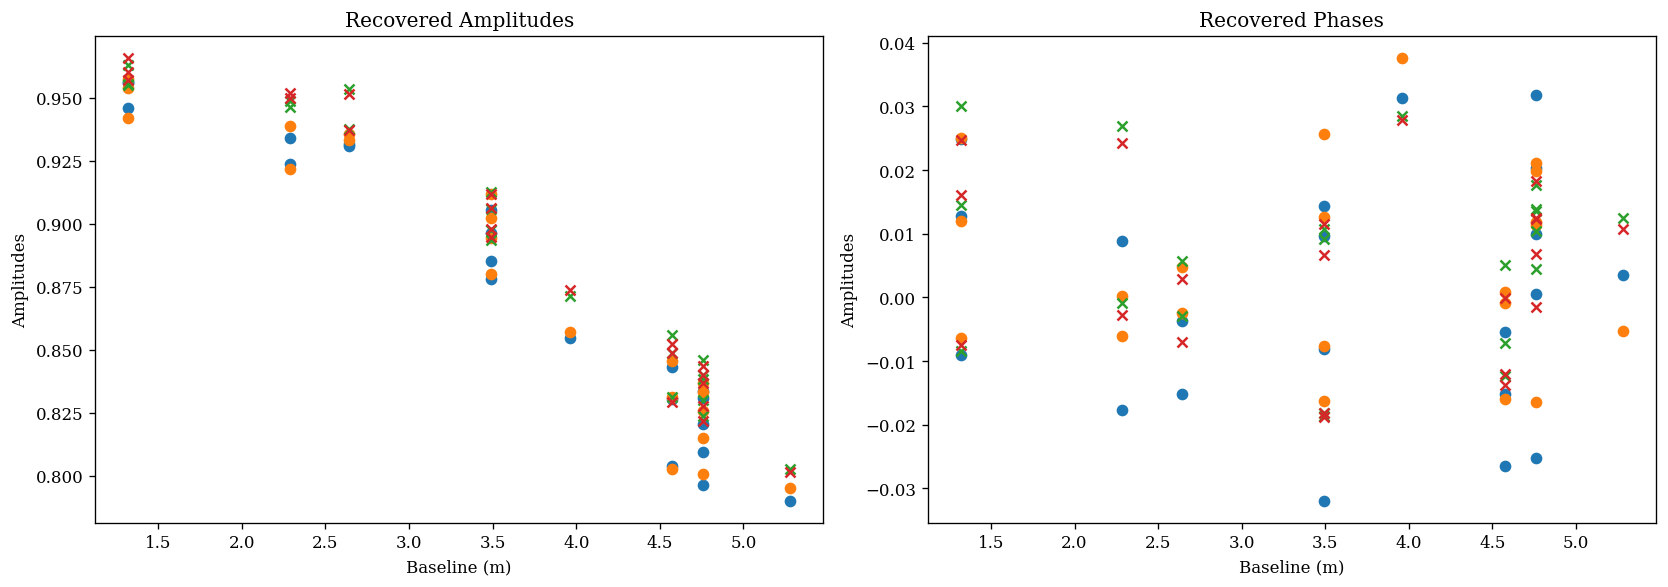

In [9]:
hbls = pairwise_vectors(mask_definitions.jwst_g7s6c()[1])
bls_r = np.array(np.hypot(hbls[:, 0], hbls[:, 1]))
# bls_r = np.concatenate([np.zeros(1), bls_r])  # Add DC term


plt.figure(figsize=(14, 5))

for vis in visibilities["sci"]:
    ampls = np.abs(vis)
    phases = np.angle(vis)

    plt.subplot(1, 2, 1)
    plt.title("Recovered Amplitudes")
    # plt.errorbar(bls_r, models_out[-1].amplitudes, yerr=ampl_err, fmt="o", capsize=5)
    plt.scatter(bls_r, ampls)
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

    plt.subplot(1, 2, 2)
    plt.title("Recovered Phases")
    # plt.errorbar(bls_r, models_out[-1].phases, yerr=phase_err, fmt="o", capsize=5)
    plt.scatter(bls_r, phases)
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

for vis in visibilities["cal"]:
    ampls = np.abs(vis)
    phases = np.angle(vis)

    plt.subplot(1, 2, 1)
    plt.title("Recovered Amplitudes")
    # plt.errorbar(bls_r, models_out[-1].amplitudes, yerr=ampl_err, fmt="o", capsize=5)
    plt.scatter(bls_r, ampls, marker="x")
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

    plt.subplot(1, 2, 2)
    plt.title("Recovered Phases")
    # plt.errorbar(bls_r, models_out[-1].phases, yerr=phase_err, fmt="o", capsize=5)
    plt.scatter(bls_r, phases, marker="x")
    plt.ylabel("Amplitudes")
    plt.xlabel("Baseline (m)")

plt.tight_layout()
plt.show()